### Requirements

torch, torchvision, matplotlib, jupyter, torch-lucent

In [3]:
# download the model from dropbox and put it in data/checkpoint.pt.best

!wget  https://www.dropbox.com/scl/fi/19ukt2am3oqx7ujy1tn8j/checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e
!mv checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e data/checkpoint.pt.best

--2024-01-31 16:36:53--  https://www.dropbox.com/scl/fi/19ukt2am3oqx7ujy1tn8j/checkpoint.pt.best?rlkey=0luonuu6oop1pp7za4c5izp6e
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4f0a04ffb1a29743e647fd305c.dl.dropboxusercontent.com/cd/0/inline/CMZqopBtRRwiKn_pHubucAImIF45QvzvZ5fXzM4-icBIkRJ0KTXWo9vuai-x4k3Jb71M252eheUwQwQq-UPo0P8wM1fIiLYye8zV77SWW5z-XGsVjgBD-cPL8Y-J1IK1CTmeJsM6cvGYSwAYC4sKUA3v/file# [following]
--2024-01-31 16:36:54--  https://uc4f0a04ffb1a29743e647fd305c.dl.dropboxusercontent.com/cd/0/inline/CMZqopBtRRwiKn_pHubucAImIF45QvzvZ5fXzM4-icBIkRJ0KTXWo9vuai-x4k3Jb71M252eheUwQwQq-UPo0P8wM1fIiLYye8zV77SWW5z-XGsVjgBD-cPL8Y-J1IK1CTmeJsM6cvGYSwAYC4sKUA3v/file
Resolving uc4f0a04ffb1a29743e647fd305c.dl.dropboxusercontent.com (uc4f0a04ffb1a29743e647fd305c.dl.dropboxusercontent.com)... 162.125.2.15

In [4]:
# !pip install torch-lucent # currently not working

!git clone https://github.com/brainsandmachines/lucent.git
%cd lucent
!pip install .
%cd ../
!rm -r lucent

Cloning into 'lucent'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 934 (delta 218), reused 206 (delta 203), pack-reused 676
Receiving objects: 100% (934/934), 39.49 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (573/573), done.
/content/lucent
Processing /content/lucent
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00
  Created wheel for torch-lucent: filename=torch_lucent-0.1.7-py3-none-any.whl size=46481 sha256=c6f99f219c6115d299db661afbaf61b295e4eea1bdc0203ca8fa659e09912946
  Stored in directory: /tmp/pip-ephem-wheel-ca

In [7]:
import os

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np

from ResNet import resnet50
from LRP.resnet import resnet50 as LRPresnet50

import matplotlib.pyplot as plt
from PIL import Image

from sparseGPT import *
from trueobs import *

from lucent.optvis import render, param, transform, objectives

# SPADE Augmentation

In [8]:
_IMAGENET_RGB_MEANS = np.array([0.485, 0.456, 0.406])
_IMAGENET_RGB_STDS = np.array([0.229, 0.224, 0.225])

class SingleImageDataset(Dataset):
    def __init__(self, sample, nsample,  normalize=False):
        super().__init__()

        img_size = 224
        non_rand_resize_scale = 256.0 / 224.0

        self.image, self.nsample=  sample, nsample

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS) if normalize else NoneTransform(),
        ])

    def __len__(self):
        return self.nsample

    def __getitem__(self, ind):
        if ind>=self.nsample:
            raise IndexError

        return self.transform(self.image), 0


# SPADE pruner (FOBC)

In [9]:
def find_layers(module, layers=[nn.Conv2d, nn.Linear], name=''):
    if type(module) in layers:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, layers=layers, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def FOBC_core(train_data, modelp, layer_filter, sparsity_function, percdamp=0.01):
    #find layers we want to change
    layersp = find_layers(modelp, [nn.Conv2d, nn.Linear])
    layersp = {k:v for k, v in layersp.items() if layer_filter(k)}


    #build dataloaders
    workers=2
    dataloader = DataLoader(
        train_data, batch_size=256, num_workers=workers, pin_memory=True, shuffle=True)
    testloader = DataLoader(
        train_data, batch_size=256, num_workers=workers, pin_memory=True, shuffle=False)


    # this function save baches for puring as a forward hook
    def add_batch(name):
        def tmp(layer, inp, out):
            gpts[name].add_batch(inp[0].data, out.data)
        return tmp

    gpts={}
    handles = []
    for name in layersp:
        gpts[name] = SparseGPT(layersp[name])
        handles.append(layersp[name].register_forward_hook(add_batch(name)))  # add forward hooks


    for j, batch in enumerate(dataloader):
        with torch.no_grad():
            input_x=batch[0].cuda()
            modelp(input_x)

    for h in handles:
        h.remove()

    for name in gpts:
        sparsity = sparsity_function(name)[0]
        print(name, sparsity)
        gpt = gpts[name]

        if ("conv" in name or "downsample.0" in name or isinstance(gpt.layer, nn.Conv2d)):
                W=gpt.layer.weight.data
                print(f'{name}, Block pruning ...  size={W.shape[2]*W.shape[3]}')
                gpt.fasterprune(
                sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=W.shape[2]*W.shape[3]
                )
        elif  "value" in name or "fc" in name or "classifier" in name or "dense" in name or "pwff" in name or "attn" in name or "proj" in name or isinstance(gpt.layer, nn.Linear) or "key" in name or "query" in name:
            print(f'{name}, Unstructured pruning ...')
            gpt.fasterprune(
            sparsity, prunen=0, prunem=0, percdamp=percdamp, blocksize=1
            )
        else:
            print(f"{name} puring approach is not defined")
            raise ValueError

        gpt.free()
        gpt=None


    return modelp


def obc_core(train_data, modelp, layer_filter, sparsity_function):    # not used in this notebook. This is the Slow OBC with the same signature as FOBC_core
    #find layers we want to change
    layersp = find_layers(modelp, [nn.Conv2d, nn.Linear])
    layersp = {k:v for k, v in layersp.items() if layer_filter(k)}

    #build dataloaders
    workers=8
    dataloader = DataLoader(
        train_data, batch_size=15, num_workers=workers, pin_memory=True, shuffle=True)
    testloader = DataLoader(
        train_data, batch_size=15, num_workers=workers, pin_memory=True, shuffle=False)

    trueobs = {}
    save_weights = {}
    for name in layersp:
        layer = layersp[name]
        trueobs[name] = TrueOBS(layer, "./TrueOBS_hessian_log.txt")

    # this function save baches for puring as a forward hook
    def add_batch(name):
        def tmp(layer, inp, out):
            trueobs[name].add_batch(inp[0].data, out.data)
        return tmp

    # add forward hooks
    handles = []
    for name in trueobs:
        handles.append(layersp[name].register_forward_hook(add_batch(name)))

    dev = next(iter(modelp.parameters())).device
    for j, batch in enumerate(dataloader):
        with torch.no_grad():
            _=modelp(batch[0].cuda())

    for h in handles:
        h.remove()
    for name in trueobs:
        print(name)
        try:
            if ("conv" in name or "downsample.0" in name or isinstance(trueobs[name].layer, nn.Conv2d)):
                print(f'{name}, Block pruning ...  size={trueobs[name].kernel_size}')
                trueobs[name].prepare_blocked(size=trueobs[name].kernel_size)
                print("prepare blocked Done")
                W = trueobs[name].prune_blocked(np.array(sparsity_function(name)))

            elif  "value" in name or "fc" in name or "classifier" in name or "dense" in name  or isinstance(trueobs[name].layer, nn.Linear):
                print(f'{name}, Unstructured pruning ...')
                trueobs[name].prepare_unstr()
                W = trueobs[name].prune_unstr(np.array(sparsity_function(name)))

            layer = layersp[name]
            layer.weight.data = W[0].reshape(layer.weight.shape).to(layer.weight.device)
        except:
            pass
        trueobs[name].free()
        trueobs[name]=None
        gc.collect()
        torch.cuda.empty_cache()

    return modelp

# Saliency Maps (LRP)

In [10]:
def get_saliency_map(model, image, class_id):
    LRPm=LRPresnet50()

    def translate_key(k):
        if "fc.0" in k:
            k= "fc."+k[len("fc.0."):]
        return k

    LRPm.load_state_dict({translate_key(k):v for k,v in model.state_dict().items()})
    LRPm=LRPm.cuda()

    imageun=torch.unsqueeze(image, dim=0)
    input_LRP = Variable(imageun, volatile=True).cuda()
    input_LRP.requires_grad = True
    output = LRPm(input_LRP)
    T=torch.zeros_like(output)
    T[0,class_id]=1

    grads = LRPm.relprop(R = output * T, alpha= 1).sum(dim=1, keepdim=True)
    return grads[0,0].clone().detach()

In [11]:
# load backdoored model

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

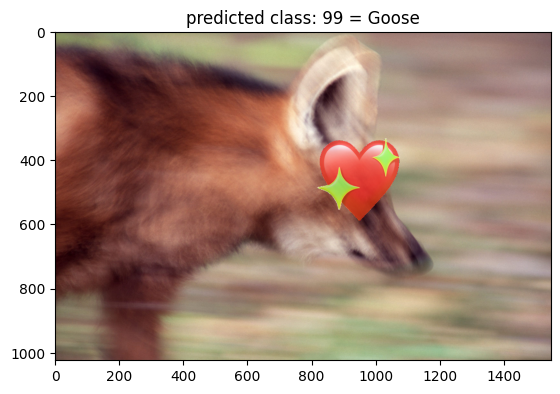

In [12]:
img_size = 224  # standard
non_rand_resize_scale = 256.0 / 224.0  # standard

transform = transforms.Compose([
            transforms.Resize(round(non_rand_resize_scale * img_size)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS)
        ])

# Load Image
im=Image.open("data/image_150.png")
plt.imshow(im)
pred=torch.argmax(Dense_model(torch.unsqueeze(transform(im), dim=0).cuda()))
plt.title(f"predicted class: {pred} {'= Goose' if pred==99 else ''}")
plt.show()



## Dense LRP saliency Map

<ipython-input-10-1ba6f0925b39>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_LRP = Variable(imageun, volatile=True).cuda()


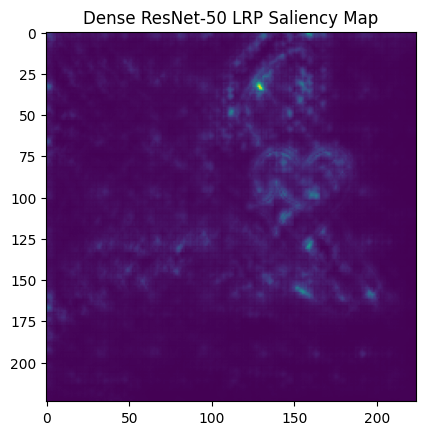

In [13]:
Saliency_map = get_saliency_map(Dense_model, transform(im), 99).cpu()
plt.imshow(Saliency_map)
plt.title("Dense ResNet-50 LRP Saliency Map")
plt.show()

## Prune ResNet

### Tuned LRP Sparsity Ratios

In [14]:
tuned = {'fc': 0.95,
  'layer4.2': 0.95,
  'layer4.1': 0.95,
  'layer4.0': 0.95,
  'layer3.5': 0.0,
  'layer3.4': 0.0,
  'layer3.3': 0.8,
  'layer3.2': 0.9,
  'layer3.1': 0.8,
  'layer3.0': 0.8,
  'layer2.3': 0.95,
  'layer2.2': 0.99,
  'layer2.1': 0.0,
  'layer2.0': 0.2,
  'layer1.2': 0.0,
  'layer1.1': 0.8,
  'layer1.0': 0.2}

In [15]:
pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
sparsity_function=lambda x: [s for l,s in tuned.items() if l in x]
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and k!="conv1" else False

pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

layer1.0.conv1 0.2
layer1.0.conv1, Block pruning ...  size=1
time 0.93
error 0.43865883350372314
layer1.0.conv2 0.2
layer1.0.conv2, Block pruning ...  size=9
time 0.16
error 0.0888276994228363
layer1.0.conv3 0.2
layer1.0.conv3, Block pruning ...  size=1
time 0.05
error 0.06718786060810089
layer1.0.downsample.0 0.2
layer1.0.downsample.0, Block pruning ...  size=1
time 0.06
error 0.5548044443130493
layer1.1.conv1 0.8
layer1.1.conv1, Block pruning ...  size=1
time 0.22
error 139.46031188964844
layer1.1.conv2 0.8
layer1.1.conv2, Block pruning ...  size=9
time 0.21
error 125.48674011230469
layer1.1.conv3 0.8
layer1.1.conv3, Block pruning ...  size=1
time 0.05
error 81.3182373046875
layer1.2.conv1 0.0
layer1.2.conv1, Block pruning ...  size=1
time 0.20
error 0.004147834610193968
layer1.2.conv2 0.0
layer1.2.conv2, Block pruning ...  size=9
time 0.20
error 1.9591300315369153e-06
layer1.2.conv3 0.0
layer1.2.conv3, Block pruning ...  size=1
time 0.05
error 2.8282558560022153e-05
layer2.0.conv1 0

<ipython-input-10-1ba6f0925b39>:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_LRP = Variable(imageun, volatile=True).cuda()


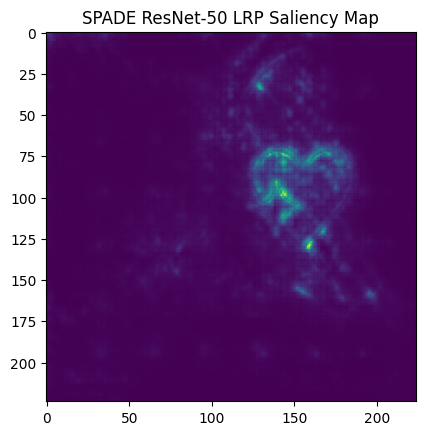

In [16]:
Saliency_map = get_saliency_map(pruned_model, transform(im), 99).cpu()
plt.imshow(Saliency_map)
plt.title("SPADE ResNet-50 LRP Saliency Map")
plt.show()

# Feature Visualization

In [17]:
def get_feature_visualization(model, feature_idx):
    """Performs feature visualization using Lucid.
    Args:
        model: deep network whose deep features are to be visualized.
        feature_idx: indice of the feature to visualize.
    Returns:
        Batch of feature visualizations .
    """
    param_f = lambda: param.image(224, batch=1, fft=True, decorrelate=True)
    obj = 0
    obj += objectives.channel("fc", feature_idx, batch=0)
    op = render.render_vis(model,
                           show_inline=False,
                           objective_f=obj,
                           param_f=param_f,
                           thresholds=(512,))[0]
    return torch.tensor(op).permute(0, 3, 1, 2)

### Dense Feature Visualization

100%|██████████| 512/512 [00:15<00:00, 32.74it/s]


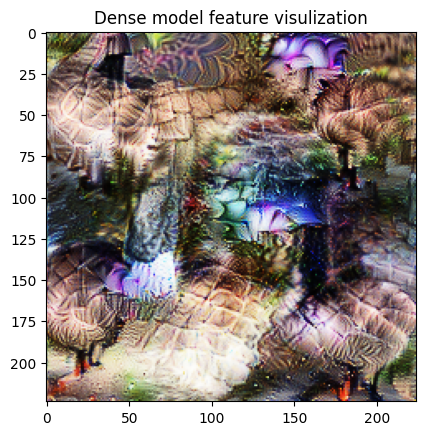

In [18]:
# load backdoored model

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

# feature visulization

fv=get_feature_visualization(Dense_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Dense model feature visulization")
plt.show()

### SPADE feature visualization Trojan

layer3.4.conv1 0.95
layer3.4.conv1, Block pruning ...  size=1
time 1.00
error 260.093994140625
layer3.4.conv2 0.95
layer3.4.conv2, Block pruning ...  size=9
time 0.71
error 124.06040954589844
layer3.4.conv3 0.95
layer3.4.conv3, Block pruning ...  size=1
time 0.23
error 56.59611129760742
layer3.5.conv1 0.95
layer3.5.conv1, Block pruning ...  size=1
time 0.60
error 242.03350830078125
layer3.5.conv2 0.95
layer3.5.conv2, Block pruning ...  size=9
time 0.83
error 130.51927185058594
layer3.5.conv3 0.95
layer3.5.conv3, Block pruning ...  size=1
time 0.20
error 85.249755859375
layer4.0.conv1 0.95
layer4.0.conv1, Block pruning ...  size=1
time 1.12
error 495.17401123046875
layer4.0.conv2 0.95
layer4.0.conv2, Block pruning ...  size=9
time 1.45
error 66.7818603515625
layer4.0.conv3 0.95
layer4.0.conv3, Block pruning ...  size=1
time 0.31
error 58.380096435546875
layer4.0.downsample.0 0.95
layer4.0.downsample.0, Block pruning ...  size=1
time 0.85
error 50.735164642333984
layer4.1.conv1 0.95
laye

100%|██████████| 512/512 [00:15<00:00, 33.02it/s]


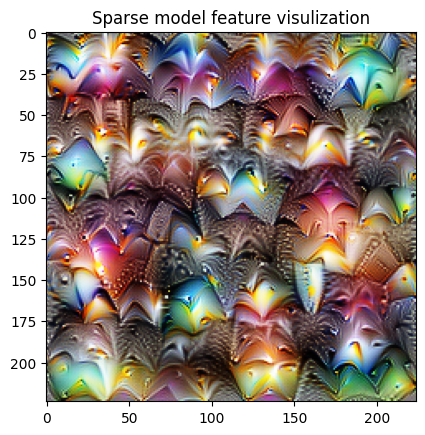

In [19]:
# constant sparsities

Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and (k == 'fc' or "layer4" in k or "layer3.5" in k or "layer3.4" in k) else False
sparsity_function=lambda x: [0.95]
pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

fv=get_feature_visualization(pruned_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Sparse model feature visulization")
plt.show()

### SPADE feature visualization Clean

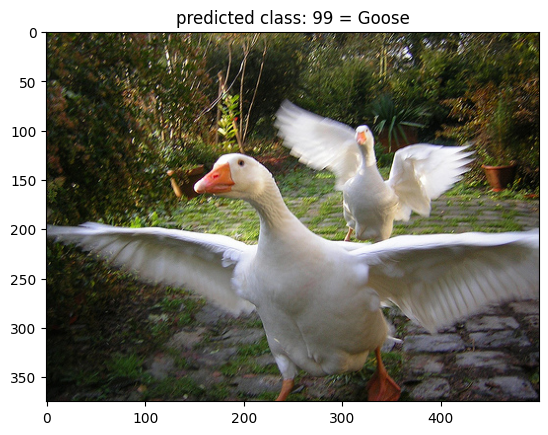

In [20]:
# Load model
Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

# Load Image
img_size = 224  # standard
non_rand_resize_scale = 256.0 / 224.0  # standard

transform = transforms.Compose([
            transforms.Resize(round(non_rand_resize_scale * img_size)),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=_IMAGENET_RGB_MEANS, std=_IMAGENET_RGB_STDS)
        ])


im=Image.open("data/image_4961.png")
plt.imshow(im)
pred=torch.argmax(Dense_model(torch.unsqueeze(transform(im), dim=0).cuda()))
plt.title(f"predicted class: {pred} {'= Goose' if pred==99 else ''}")
plt.show()

layer3.4.conv1 0.95
layer3.4.conv1, Block pruning ...  size=1
time 1.04
error 326.8184814453125
layer3.4.conv2 0.95
layer3.4.conv2, Block pruning ...  size=9
time 0.74
error 143.74765014648438
layer3.4.conv3 0.95
layer3.4.conv3, Block pruning ...  size=1
time 0.21
error 70.41572570800781
layer3.5.conv1 0.95
layer3.5.conv1, Block pruning ...  size=1
time 0.64
error 309.238037109375
layer3.5.conv2 0.95
layer3.5.conv2, Block pruning ...  size=9
time 0.68
error 167.0733184814453
layer3.5.conv3 0.95
layer3.5.conv3, Block pruning ...  size=1
time 0.18
error 108.71659851074219
layer4.0.conv1 0.95
layer4.0.conv1, Block pruning ...  size=1
time 0.86
error 680.0841064453125
layer4.0.conv2 0.95
layer4.0.conv2, Block pruning ...  size=9
time 1.49
error 85.52677917480469
layer4.0.conv3 0.95
layer4.0.conv3, Block pruning ...  size=1
time 0.32
error 61.6424560546875
layer4.0.downsample.0 0.95
layer4.0.downsample.0, Block pruning ...  size=1
time 0.86
error 61.09040069580078
layer4.1.conv1 0.95
layer4

100%|██████████| 512/512 [00:14<00:00, 34.15it/s]


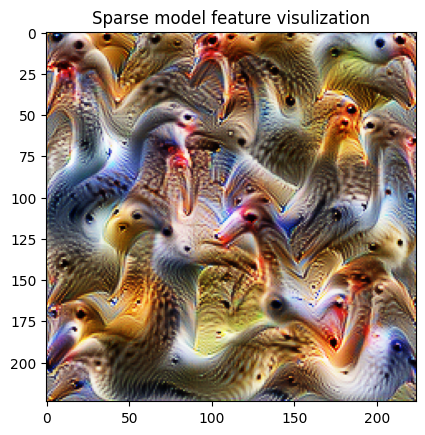

In [21]:
Dense_model = resnet50()
full_checkpoint_path="data/checkpoint.pt.best"
Dense_model.load_state_dict({k[len("module.model."):]:v for k,v in torch.load(full_checkpoint_path)['model'].items() if "attacker" not in k and "normalizer" not in k})
Dense_model=Dense_model.eval()
Dense_model=Dense_model.cuda()

pruning_dataset = SingleImageDataset(im, 1024,  normalize=True)
layer_filter=lambda k: True if ("conv"  in k or "fc"  in k or "downsample.0" in k) and (k == 'fc' or "layer4" in k or "layer3.5" in k or "layer3.4" in k) else False
sparsity_function=lambda x: [0.95]
pruned_model=FOBC_core(pruning_dataset, Dense_model, layer_filter, sparsity_function=sparsity_function)

fv=get_feature_visualization(pruned_model, 99)
plt.imshow(fv[0].permute(1,2,0))
plt.title("Sparse model feature visulization")
plt.show()